# GPX file reading and datascience

In [1]:
import gpxpy
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns  
from math import radians, sin, cos, sqrt, atan2, tan
%matplotlib inline 

### Reading a gpx file and inserting its data in a dtaframe

In [27]:
# Load the GPX file

gpx_file = open('output_trimmed5.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

# Create empty lists to store data
latitude = []
longitude = []
elevation = []
time = []
heartrate = []

# Iterate through the GPX data points
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            latitude.append(point.latitude)
            longitude.append(point.longitude)
            elevation.append(point.elevation if point.elevation is not None else 0)  # Handle None values
            time.append(point.time)
            if point.extensions:
                for ext in point.extensions:
                    for extchild in list(ext):
                        heartrate.append(int(extchild.text))
            else:
                heartrate.append(0)
                

# Create a DataFrame
data = {
    'Time': time,
    'Latitude': latitude,
    'Longitude': longitude,
    'Elevation': elevation,
    'Heartrate':heartrate
    
}
df = pd.DataFrame(data)

# Close the GPX file
gpx_file.close()

df


,Time,Latitude,Longitude,Elevation,Heartrate
0,2023-11-19 11:36:03+00:00,41.313104,1.938426,410.76,0
1,2023-11-19 11:41:38+00:00,41.313294,1.938463,413.56,0
2,2023-11-19 11:41:44+00:00,41.313493,1.938527,414.67,0
3,2023-11-19 11:41:49+00:00,41.313697,1.938580,415.11,0
4,2023-11-19 11:41:53+00:00,41.313902,1.938692,415.76,0
...,...,...,...,...,...
685,2023-11-19 12:22:59+00:00,41.269990,1.943831,22.61,0
686,2023-11-19 12:23:04+00:00,41.270173,1.943865,22.99,0
687,2023-11-19 12:23:10+00:00,41.270359,1.943876,23.26,0
688,2023-11-19 12:23:16+00:00,41.270560,1.943931,23.43,0


### Calculating some common parameters

In [28]:
# Cumulative Time

df['Cumulative_Time'] = (df['Time'] - df['Time'].min()).dt.total_seconds() / 60.0


# Cumulative_Distance in km

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)

    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c  # Distance in kilometers
    return distance

df['Cumulative_Distance'] = np.cumsum(haversine(df['Latitude'].shift(), df['Longitude'].shift(), df['Latitude'], df['Longitude']).fillna(0))

# Velocity in km/h

df['Velocity'] = (df['Cumulative_Distance'].diff() / df['Cumulative_Time'].diff()) * 60  # Convert from minutes to hours

# Slope in degrees

skip_values = 2  # Set the number of values to skip for smoothing

df['Slope'] = np.degrees(np.arctan2(df['Elevation'].diff(periods=skip_values), df['Cumulative_Distance'].diff(periods=skip_values)*1000))


# Smoothed elevation

df['Smoothed_Elevation'] = df['Elevation'].rolling(window=10, min_periods=1).mean()


# Cumulative elevation

positive_changes = df['Smoothed_Elevation'].diff().clip(lower=0)
df['Cumulative_Elevation'] = positive_changes.cumsum()

# Smoothed Slope
df['Smooth_Slope'] = np.degrees(np.arctan2(df['Smoothed_Elevation'].diff(), df['Cumulative_Distance'].diff()*1000))


# Removing velocity outliers

# Calculate the average of adjacent values for each row
df['average_adjacent'] = df['Velocity'].rolling(window=3, center=False).mean()

# Identify the rows where the velocity is 2 or 3 times larger than the average of adjacent values
outlier_condition = (df['Velocity'] > (df['average_adjacent'] + 20))

# Create a new column 'corrected_velocity' with the corrected values
df['Corrected_Velocity'] = np.where(outlier_condition, df['average_adjacent'], df['Velocity'])

# Substitute values higher than 80 km/h
df['Corrected_Velocity'] = df['Corrected_Velocity'].apply(lambda x: df['Corrected_Velocity'].mean() if x>80 else x )


# Drop the 'average_adjacent' column
df.drop(columns=['average_adjacent'], inplace=True)

# Additional smoothing
df['Corrected_Velocity']=df['Corrected_Velocity'].rolling(window=3, min_periods=1).mean()


df

,Time,Latitude,Longitude,Elevation,Heartrate,Cumulative_Time,Cumulative_Distance,Velocity,Slope,Smoothed_Elevation,Cumulative_Elevation,Smooth_Slope,Corrected_Velocity
0,2023-11-19 11:36:03+00:00,41.313104,1.938426,410.76,0,0.000000,0.000000,NaN,NaN,410.760000,NaN,NaN,NaN
1,2023-11-19 11:41:38+00:00,41.313294,1.938463,413.56,0,5.583333,0.021386,0.229820,NaN,412.160000,1.400000,3.745421,0.229820
2,2023-11-19 11:41:44+00:00,41.313493,1.938527,414.67,0,5.683333,0.044119,13.639710,5.064557,412.996667,2.236667,2.107780,6.934765
3,2023-11-19 11:41:49+00:00,41.313697,1.938580,415.11,0,5.766667,0.067237,16.644995,1.936159,413.525000,2.765000,1.309194,10.171509
4,2023-11-19 11:41:53+00:00,41.313902,1.938692,415.76,0,5.833333,0.091789,22.096569,1.309876,413.972000,3.212000,1.043037,17.460425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,2023-11-19 12:22:59+00:00,41.269990,1.943831,22.61,0,46.933333,16.184049,14.861734,4.332793,14.955000,140.694000,3.907784,19.011702
686,2023-11-19 12:23:04+00:00,41.270173,1.943865,22.99,0,47.016667,16.204644,14.828261,2.679696,16.416000,142.155000,4.057777,17.166783
687,2023-11-19 12:23:10+00:00,41.270359,1.943876,23.26,0,47.116667,16.225358,12.428272,0.901488,17.847000,143.586000,3.951967,14.039422
688,2023-11-19 12:23:16+00:00,41.270560,1.943931,23.43,0,47.216667,16.248150,13.675232,0.579446,19.140000,144.879000,3.246926,13.643922


In [29]:
# Statistics

timeMin = round(df['Cumulative_Time'].max(), 1)
timeH = round(timeMin / 60, 1)
distRound = round(df['Cumulative_Distance'].max(), 1)
max_speed = round(df['Corrected_Velocity'].max(), 1)
avg_speed = round(distRound / timeH, 1)
max_slope = round(df['Slope'].max(), 1)
max_hr = df['Heartrate'].max()
mean_hr = round(df['Heartrate'].mean())
max_height =  round(df['Elevation'].max())
min_height =  round(df['Elevation'].min())
cum_elevation =  round(df['Cumulative_Elevation'].max())

# Create a new DataFrame with the calculated values
stat_df = pd.DataFrame({
    'Tiempo en movimiento': [timeMin],
    'Tiempo en movimiento': [timeH],
    'Distancia recorrida': [distRound],
    'Velocidad Máxima': [max_speed],
    'Velocidad media': [avg_speed],
    'Max slope (º)': [max_slope],
    'Max HR (bpm)': [max_hr],
    'Mean HR (bpm)': [mean_hr],
    'Altura Máxima': [max_height],
    'Altura Mínima': [min_height],
    'Ganancia Altitud': [cum_elevation]
})

stat_df=stat_df.transpose()
stat_df.reset_index(inplace=True)
stat_df.columns = ['Parámetro', 'Valor']
stat_df

,Parámetro,Valor
0,Tiempo en movimiento,0.8
1,Distancia recorrida,16.3
2,Velocidad Máxima,58.6
3,Velocidad media,20.4
4,Max slope (º),18.7
5,Max HR (bpm),0.0
6,Mean HR (bpm),0.0
7,Altura Máxima,439.0
8,Altura Mínima,5.0
9,Ganancia Altitud,146.0


### Reading values stored as custom code in GPX files generated by Orux Maps

In [37]:
from bs4 import BeautifulSoup

with open('output_trimmed5.gpx', 'r') as file:
    gpx_file_content = file.read()

# Create a BeautifulSoup object
soup = BeautifulSoup(gpx_file_content, 'html.parser')

lst = []
# Find the <desc> tag
desc_tag = soup.find('desc')

if desc_tag:
    # Extract CDATA content within <desc>
    cdata_content = desc_tag.string
    
    if cdata_content:
        # Parse the CDATA content with BeautifulSoup
        cdata_soup = BeautifulSoup(cdata_content, 'html.parser')
        
        # Find all <br/> tags
        br_tags = cdata_soup.find_all('br')
        
        # Extract text between <br/> tags
        for br_tag in br_tags:
            # Get the next_sibling, which should be the text between <br/> tags
            text_between_br = br_tag.next_sibling
            if text_between_br and isinstance(text_between_br, str):
                extracted_text = text_between_br.strip()
                lst.append(extracted_text)
    else:
        print("No CDATA content found within <desc>.")
else:
    print("No <desc> tag found in the content.")


stat_df_Orux=pd.DataFrame(lst)

stat_df_Orux['Parámetro'] = stat_df_Orux[0].apply(lambda x: x.split(':',maxsplit=1)[0]).apply(lambda x: x.replace('Ã¡','á')).apply(lambda x: x.replace('Ã','í')).apply(lambda x: x.replace('Ã©','é'))
stat_df_Orux['Valor'] = stat_df_Orux[0].apply(lambda x: x.split(':',maxsplit=1)[1]).apply(lambda x: x.split()[0]).apply(lambda x: x.replace(',','.')).apply(lambda x: x[:-2] if x.endswith('km') else x)
#stat_df_Orux['ValueRaw'] = stat_df_Orux['ValueRaw']
stat_df_Orux.drop(0, axis=1, inplace=True)

stat_df_Orux

d:\Programas\Anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


,Parámetro,Valor
0,Hora Inicio,12:36
1,Hora Fin,13:23
2,Distancia recorrida,16.3
3,Tiempo en movimiento,00:41
4,Velocidad media,20.62
5,Vel. en Mov.,23.14
6,Velocidad Máxima,55.2
7,Altura Mínima,5
8,Altura Máxima,439
9,Velocidad Ascenso,585.7


### Comparing the values calculated by Orux Maps and stored in the gpx file with the ones calculated by the present code

In [38]:
stat_df_new=pd.merge(stat_df,stat_df_Orux,on='Parámetro', how='outer')
stat_df_new.columns = ['Prámetro','Mis valores', 'Valores Orux']
stat_df_new

,Prámetro,Mis valores,Valores Orux
0,Tiempo en movimiento,0.8,00:41
1,Distancia recorrida,16.3,16.3
2,Velocidad Máxima,58.6,55.2
3,Velocidad media,20.4,20.62
4,Max slope (º),18.7,NaN
5,Max HR (bpm),0.0,NaN
6,Mean HR (bpm),0.0,NaN
7,Altura Máxima,439.0,439
8,Altura Mínima,5.0,5
9,Ganancia Altitud,146.0,241


### Generating some common plots

Text(0, 0.5, 'Corrected Velocity (km/h)')

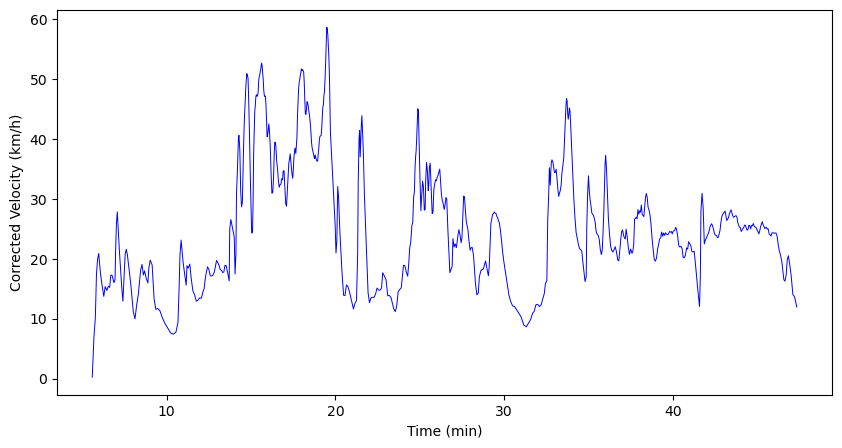

In [39]:
#Plotting velocity

plt.figure(figsize=(10,5))
y=df['Corrected_Velocity']
x=df['Cumulative_Time']
plt.plot(x, y, 'b', lw = '0.7') # 'r' is the color red
#plt.xlim(140,150)
#plt.ylim(0,10)
plt.xlabel('Time (min)')
plt.ylabel('Corrected Velocity (km/h)')

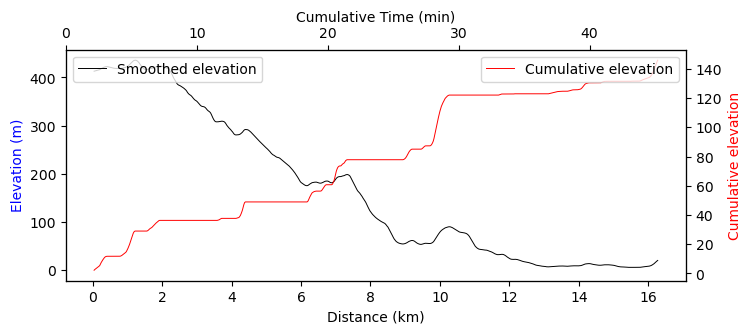

In [40]:
# Plotting elevation

fig, ax1 = plt.subplots(figsize=(8, 3))

# Plot Elevation against Cumulative Distance on the first y-axis
#ax1.plot(df['Cumulative_Distance'][2:], df['Elevation'][2:], label='Elevation', color='blue', lw = 0.7)
ax1.plot(df['Cumulative_Distance'][2:], df['Smoothed_Elevation'][2:], label='Smoothed elevation', color='black', lw = 0.7)
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Elevation (m)', color='blue')


# Create a second y-axis for cum elevation
ax2 = ax1.twinx()
ax2.plot(df['Cumulative_Distance'][2:], df['Cumulative_Elevation'][2:], label='Cumulative elevation', color='red', lw = 0.7)
ax2.set_ylabel('Cumulative elevation', color='red')

# Create a second x-axis for Cumulative Time
ax3 = ax1.twiny()
ax3.plot(df['Cumulative_Time'], np.zeros_like(df['Cumulative_Time']), alpha=0)  # Plot a dummy line for the x-axis
ax3.set_xlim(df['Cumulative_Time'].iloc[0], df['Cumulative_Time'].iloc[-1])
ax3.set_xlabel('Cumulative Time (min)')

# Format the axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

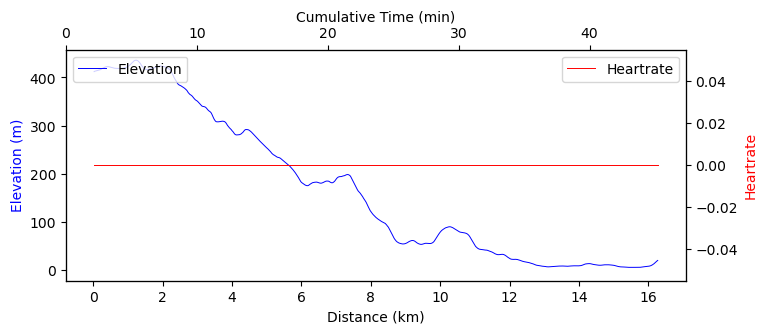

In [41]:
# Plotting elevation and HR

fig, ax1 = plt.subplots(figsize=(8, 3))

# Plot Elevation against Cumulative Distance on the first y-axis
ax1.plot(df['Cumulative_Distance'][1:], df['Smoothed_Elevation'][1:], label='Elevation', color='blue', lw = 0.7)
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Elevation (m)', color='blue')

# Create a second y-axis for Heartrate
ax2 = ax1.twinx()
ax2.plot(df['Cumulative_Distance'][1:], df['Heartrate'][1:], label='Heartrate', color='red', lw = 0.7)
ax2.set_ylabel('Heartrate', color='red')

# Create a second x-axis for Cumulative Time
ax3 = ax1.twiny()
ax3.plot(df['Cumulative_Time'], np.zeros_like(df['Cumulative_Time']), alpha=0)  # Plot a dummy line for the x-axis
ax3.set_xlim(df['Cumulative_Time'].iloc[0], df['Cumulative_Time'].iloc[-1])
ax3.set_xlabel('Cumulative Time (min)')

# Format the axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

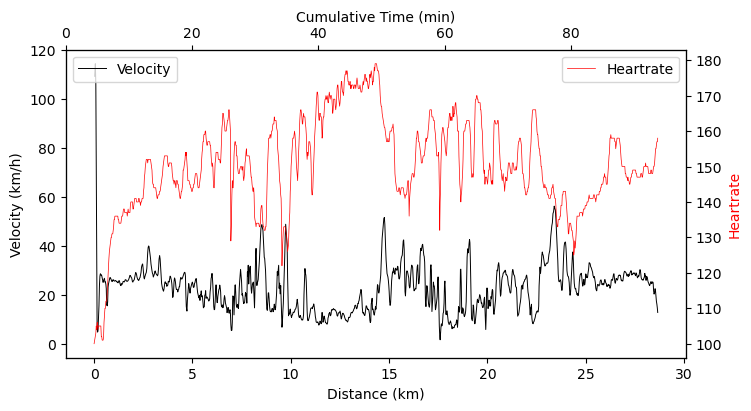

In [ ]:
# Plotting velocity and heartrate


fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot Elevation against Cumulative Distance on the first y-axis
ax1.plot(df['Cumulative_Distance'], df['Corrected_Velocity'], label='Velocity', color='black', lw = 0.7)
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Velocity (km/h)', color='black')

# Create a second y-axis for Slope
ax2 = ax1.twinx()
ax2.plot(df['Cumulative_Distance'], df['Heartrate'], label='Heartrate', color='red', lw = 0.5)
ax2.set_ylabel('Heartrate', color='red')

# Create a second x-axis for Cumulative Time
ax3 = ax1.twiny()
ax3.plot(df['Cumulative_Time'], np.zeros_like(df['Cumulative_Time']), alpha=0)  # Plot a dummy line for the x-axis
ax3.set_xlim(df['Cumulative_Time'].iloc[0], df['Cumulative_Time'].iloc[-1])
ax3.set_xlabel('Cumulative Time (min)')

# Format the axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

### Plotting the track on top of an OpenTopo map layer. Maximum speed and heartrate are displayed at the location where they were reached

In [42]:
import folium

# Create a Folium map centered around the mean coordinates
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=15)

# Add the OpenTopoMap layer
opentopomap_url = 'https://a.tile.opentopomap.org/{z}/{x}/{y}.png'
folium.TileLayer(opentopomap_url, attr='OpenTopoMap').add_to(my_map)

# Create a PolyLine connecting the data points
points = list(zip(df['Latitude'], df['Longitude']))
folium.PolyLine(points, color='blue', weight=2.5, opacity=1).add_to(my_map)

# Plot data values using CircleMarkers (hidden markers)
for index, row in df.iterrows():
    popup_content = (
        f"Speed (km/h): {round(row['Corrected_Velocity'], 1)} <br> "
        f"HR (bpm): {row['Heartrate']} <br> "
        f"Time (min): {round(row['Cumulative_Time'], 1)} <br> "
        f"Distance (km): {round(row['Cumulative_Distance'], 2)} <br> "
        f"Slope: {round(row['Slope'], 1)}"
    )

    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=0.9,  # Set radius to 0 to hide the marker
                        color='blue',
                        fill_color='blue',
                        fill_opacity=0,
                        popup=folium.Popup(popup_content, max_width=300)).add_to(my_map)

# Add a marker for the maximum heart rate

max_hr_row = df.loc[df['Heartrate'].idxmax()]

folium.map.Marker(
    [max_hr_row['Latitude'], max_hr_row['Longitude']],
    icon=folium.DivIcon(html=f'<div style="font-size: 14px; color: black;">Max HR: {max_hr_row["Heartrate"]}</div>')
).add_to(my_map)

# Add a marker for the maximum speed

max_velocity_row = df.loc[df['Corrected_Velocity'].idxmax()]

folium.map.Marker(
    [max_velocity_row['Latitude'], max_velocity_row['Longitude']],
    icon=folium.DivIcon(html=f'<div style="font-size: 14px; color: black;">Max speed: {round(max_velocity_row["Corrected_Velocity"])}</div>')
).add_to(my_map)


my_map

### Generating some scatter plots

Text(0, 0.5, 'Slope (º)')

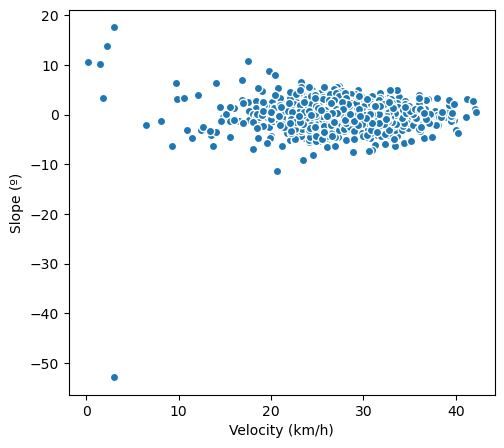

In [ ]:
plt.figure(figsize=(5.5,5))

plt.scatter(df['Velocity'],df['Slope'],edgecolors='white')
plt.xlabel('Velocity (km/h)')
plt.ylabel('Slope (º)')

Text(0, 0.5, 'Heartrate (bpm)')

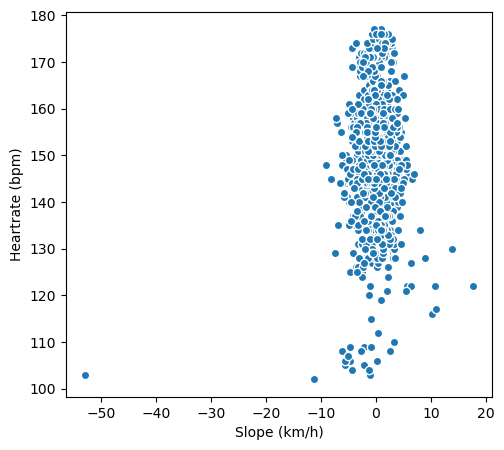

In [ ]:
plt.figure(figsize=(5.5,5))

plt.scatter(df['Slope'],df['Heartrate'],edgecolors='white')
plt.xlabel('Slope (km/h)')
plt.ylabel('Heartrate (bpm)')

Text(0, 0.5, 'Velocity')

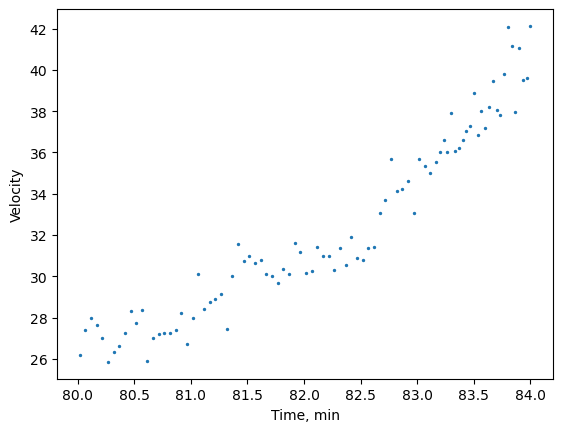

In [ ]:
#Plotting velocity
start_time = 80
end_time = 84

# Filter DataFrame based on cumulative time
filtered_df = df[(df['Cumulative_Time'] >= start_time) & (df['Cumulative_Time'] <= end_time)]

# Plot the data
plt.scatter(filtered_df['Cumulative_Time'],filtered_df['Velocity'],s=2)

plt.xlabel('Time, min')
plt.ylabel('Velocity')

### Plotting heartrate vs velocity to find VO2max (Conconi test)

Text(0, 0.5, 'Heartrate')

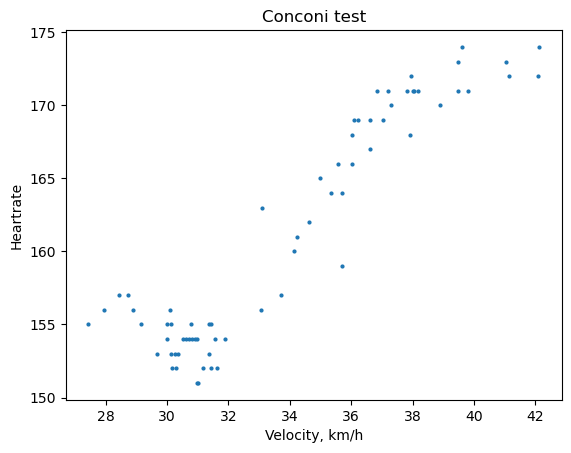

In [ ]:
# Specify the time range where the Conconi test was performed 
# (use the velocity-time plot above to find the exact start and end times for the test) 
'''
start_time = 39
end_time = 43.2
'''
start_time = 81
end_time = 84

# Filter DataFrame based on cumulative time
filtered_df = df[(df['Cumulative_Time'] >= start_time) & (df['Cumulative_Time'] <= end_time)]

# Plot the data
plt.scatter(filtered_df['Velocity'],filtered_df['Heartrate'],s=4)

plt.title('Conconi test')
plt.xlabel('Velocity, km/h')
plt.ylabel('Heartrate')

The heartrate corresponding to VO2max is at the bending of the typically sigmoid curve. In this case, it is ca. 172 bpm.

### Trimming the track from a specified time on

In [25]:
# Trim track: Specify the minutes (check on the map) to find the row
target_value = 45.5

# Find the row number corresponding to the target value
row_number = df[(round(df['Cumulative_Time'],1)) == target_value ].index.item()

print(f"The row number corresponding to {target_value} min in 'Cumulative_Time' is {row_number}")
pd.DataFrame(df.iloc[row_number]).transpose()

The row number corresponding to 45.5 min in 'Cumulative_Time' is 663


,Time,Latitude,Longitude,Elevation,Heartrate,Cumulative_Time,Cumulative_Distance,Velocity,Slope,Smoothed_Elevation,Cumulative_Elevation,Smooth_Slope,Corrected_Velocity
663,2023-11-19 12:21:33+00:00,41.266496,1.946292,6.21,0,45.5,15.682037,24.529809,0.684876,5.969,131.67,-0.028029,25.173743


In [26]:
def trim_gpx(gpx, output_file, num_points_to_keep):
    trimmed_gpx = gpxpy.gpx.GPX()

    for track in gpx.tracks:
        trimmed_track = gpxpy.gpx.GPXTrack()
        trimmed_gpx.tracks.append(trimmed_track)

        for segment in track.segments:
            trimmed_segment = gpxpy.gpx.GPXTrackSegment()
            trimmed_track.segments.append(trimmed_segment)

            # Keep only the first 'num_points_to_keep' points
            trimmed_segment.points = segment.points[:num_points_to_keep]

    # Save the trimmed GPX file
    with open(output_file, 'w') as trimmed_gpx_file:
        trimmed_gpx_file.write(gpx.to_xml())

output_filename = 'output_trimmed5.gpx'
num_points_to_keep = row_number

trim_gpx(gpx, output_filename, row_number)
print('File',output_filename,'saved')

File output_trimmed5.gpx saved


# GPX file reading and datascience

![Map](mymap.PNG)

Sports apps usually provide limited options for reding and processing GPX data.
This Notebook reproduces some basic functionalities of such apps and adds some extra ones, providing a basis for further work. Some of its features are:

- Reading a GPX file and loading its data into a Pandas dataframe
- Calculating some common parameters such as:
 - Cumulative time
 - Cumulative distance
 - Velocity (raw and smoothed)
 - Slope (raw and smoothed)
 - Elevation (raw and smoothed)
 - Cumulative elevation
- Removal of velocity outliers
- Calculating some statistics such as:
 - Total time
 - Total distance
 - Maximum velocity
 - Average velocity
 - Maximum slope
 - Maximum heartrate
 - Minimum heartrate
 - Maximum height
 - Minimum height
 - Total accumulated elevation
 - Reading app-stored statistics from the file
- Plotting any parameter as a function of time, distance or both
- Scatter plots of heartrate vs velocity and slope vs velocity
- Conconi test plot for determining VO2max. It is essentially a heartrate/velocity plot for a specified part of the track for which velocity was increased stepwise while cycling (or running) on a horizontal and homogeneous terrain.
- Plotting the track on a map. Maximum speed and heartrate are displayed at the location where they were reached. Cumulative time, cumulative distance, instantaneous speed, and instantaneous slope can also be displayed by clicking any point on the track.
- Trimming the track from a specified time on. This is useful for removing that undesired final part of the track (somtimes recorded after switching vehicle).

An online version of the notebook is available here:
https://colab.research.google.com/github/RSPdatascience/GPX-datascience/blob/main/GPX2df-forGoogle.ipynb

https://colab.research.google.com/drive/1t45gdykNZotDiwYoqek7ZffCLWInNNVp?usp=drive_link

